In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mapping_helper_functions import convert_latitude_to_webmercator, convert_longitude_to_webmercator
from rossmo_et_ridgway import Rossmo

In [2]:
body_locations_path = '../resources/Ridgway/body_locations.csv'
ridgway_locations_path = '../resources/Ridgway/ridgway_locations.csv'
disappearances_path = '../resources/Ridgway/disappearances.csv'

df_victims = pd.read_csv(body_locations_path)
df_ridgway = pd.read_csv(ridgway_locations_path)
df_disappearances = pd.read_csv(disappearances_path)

In [3]:
R = Rossmo(
    [df_victims, df_disappearances],
    [df_ridgway],
    accuracy=10
)

In [5]:
R.rossmo_results

{(43.088560437841245, -118.44871240433636): 32.717068915669664,
 (43.088560437841245, -119.33707014932905): 34.682437729935984,
 (43.088560437841245, -120.22542789432174): 37.05202600015794,
 (43.088560437841245, -121.11378563931441): 39.98743314565731,
 (43.088560437841245, -122.0021433843071): 43.46492601750527,
 (43.088560437841245, -122.89050112929979): 41.93345235409422,
 (43.088560437841245, -123.77885887429248): 38.55971420507412,
 (43.088560437841245, -124.66721661928517): 35.89828695336977,
 (43.088560437841245, -125.55557436427785): 33.725754429271674,
 (43.088560437841245, -126.44393210927053): 31.907392724780088,
 (43.8613804516543, -118.44871240433636): 34.406605322097136,
 (43.8613804516543, -119.33707014932905): 36.71606602866065,
 (43.8613804516543, -120.22542789432174): 39.565658669124225,
 (43.8613804516543, -121.11378563931441): 43.20709975464935,
 (43.8613804516543, -122.0021433843071): 47.698818315832874,
 (43.8613804516543, -122.89050112929979): 45.76316140030635,

In [6]:
df_main['coordinates'] = list(zip(df_main['Y'], df_main['X']))
df_main['latitude_webmercator'] = convert_latitude_to_webmercator(df_main['Y'])
df_main['longitude_webmercator'] = convert_longitude_to_webmercator(df_main['X'])

## TODO: 

- have the Rossmo class do the following:
  - accept a csv, look for Y or X or Lat or Lon columns, respectively
    - converts those to 'coordinates' if that doesn't already exist, adds that column to resulting dataframe
  - convert coordinates column from df to list, so user doesn't have to
  - return the dataframe 
  - add the score_normalized column
  - set anything below q1 to score_normalized = 0 by default
- decide whether class should handle plotting as well

In [7]:
df_ridgway['coordinates'] = list(zip(df_ridgway['Y'], df_ridgway['X']))
df_ridgway['latitude_webmercator'] = convert_latitude_to_webmercator(df_ridgway['Y'])
df_ridgway['longitude_webmercator'] = convert_longitude_to_webmercator(df_ridgway['X'])


df_victims['coordinates'] = list(zip(df_victims['Y'], df_victims['X']))
df_victims['latitude_webmercator'] = convert_latitude_to_webmercator(df_victims['Y'])
df_victims['longitude_webmercator'] = convert_longitude_to_webmercator(df_victims['X'])


df_disappearances['coordinates'] = list(zip(df_disappearances['Y'], df_disappearances['X']))
df_disappearances['latitude_webmercator'] = convert_latitude_to_webmercator(df_disappearances['Y'])
df_disappearances['longitude_webmercator'] = convert_longitude_to_webmercator(df_disappearances['X'])

In [8]:
df_main.sample(5)

,X,Y,Name,description,coordinates,latitude_webmercator,longitude_webmercator
20,-122.334371,47.605024,Kimi-Kai Pitsor,NaN,"(47.6050242, -122.3343709)",6.041395e+06,-1.361820e+07
12,-122.298240,47.408226,Debra Lynn Bonner,NaN,"(47.4082257, -122.29824)",6.008963e+06,-1.361418e+07
43,-121.883755,47.508216,Tina Marie Thompson,NaN,"(47.5082156, -121.8837546)",6.025426e+06,-1.356804e+07
3,-122.287109,47.469607,Carol Ann Christensen,NaN,"(47.4696067, -122.2871089)",6.019066e+06,-1.361294e+07
35,-121.949440,47.197294,Pammy Annette Avent,NaN,"(47.197294, -121.9494399)",5.974337e+06,-1.357535e+07


In [9]:
R = Rossmo(
    df_main['coordinates'].to_list(),
    accuracy=100
)

In [10]:
rossmo_results = R.rossmo_results

In [11]:
df_rossmo_results = pd.DataFrame({'coordinates': rossmo_results.keys(), 'score': rossmo_results.values()})

In [12]:
df_rossmo_results['score_normalized'] = (
    (df_rossmo_results['score'] - df_rossmo_results['score'].min()) / (df_rossmo_results['score'].max() - df_rossmo_results['score'].min()) 
) 
df_rossmo_results.sample(5)

,coordinates,score,score_normalized
3504,"(45.5475332090646, -118.7717515843337)",40.396018,0.035265
9396,"(49.62240237280618, -126.20165272427253)",37.397869,0.022810
7282,"(48.14701871007216, -125.07101559428183)",49.218258,0.071916
1750,"(44.28291864100688, -122.48670215430312)",50.905899,0.078928
5661,"(47.02291687179862, -123.3750598992958)",74.329661,0.176240


In [13]:
stats = df_rossmo_results['score'].describe()
stats

count    10000.000000
mean        52.410373
std         18.394951
min         31.907393
25%         41.548119
50%         47.409362
75%         57.104297
max        272.615382
Name: score, dtype: float64

In [14]:
# set normalized score for score values below q1 to 0.0
q1 = stats['25%']
df_rossmo_results.loc[df_rossmo_results['score'] <= q1, ['score_normalized']] = 0.0

In [15]:
df_rossmo_results.loc[df_rossmo_results['score_normalized'] > 0].sort_values(by='score_normalized', ascending=False).head(5)

,coordinates,score,score_normalized
6248,"(47.4444550611512, -122.32518256430444)",272.615382,1.000000
6147,"(47.3741986962591, -122.24442276930512)",264.763943,0.967382
6247,"(47.4444550611512, -122.24442276930512)",250.230192,0.907003
6148,"(47.3741986962591, -122.32518256430444)",247.161891,0.894256
6348,"(47.5147114260433, -122.32518256430444)",241.660345,0.871400


In [16]:
df_rossmo_results[['latitude', 'longitude']] = pd.DataFrame(df_rossmo_results['coordinates'].tolist(), index=df_rossmo_results.index)

# convert latitude and longitude to web mercator for plotting
df_rossmo_results['latitude_webmercator'] = convert_latitude_to_webmercator(df_rossmo_results['latitude'])
df_rossmo_results['longitude_webmercator'] = convert_longitude_to_webmercator(df_rossmo_results['longitude'])

In [39]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import CARTODBPOSITRON_RETINA, get_provider
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import jitter

# show map in notebook
output_notebook()

tile_provider = get_provider(CARTODBPOSITRON_RETINA)

x_range = df_rossmo_results['longitude_webmercator'].min(), df_rossmo_results['longitude_webmercator'].max()  # lon
y_range = df_rossmo_results['latitude_webmercator'].min(), df_rossmo_results['latitude_webmercator'].max() # lat 

hover = HoverTool(
    names=['ridgway', 'victims', 'disappearances'],
    tooltips=[
        ('Name', '@Name'),
        ('Coordinates', '@coordinates'),
        ('description', '@description')
    ]
)

# range bounds supplied in web mercator coordinates
p = figure(
    x_range=x_range, # ideal coordinates top to bottom: 47.8 - 47.25, left to right: -122.65 - -121.95 
    y_range=y_range,
    x_axis_type='mercator', 
    y_axis_type='mercator',
    tools=['pan', 'wheel_zoom', 'save', 'reset', hover],
    lod_threshold=None
)
p.add_tile(tile_provider)

d = np.fliplr(
    df_rossmo_results['score_normalized']\
    .to_numpy()\
    .reshape((R.accuracy, R.accuracy))
)

# plot the heatmap
p.image(
    image=[d], 
    x=x_range[0],
    y=y_range[0],
    dw=abs(x_range[1] - x_range[0]), 
    dh=abs(y_range[1] - y_range[0]), 
    palette='Spectral10', 
    alpha=0.65
)

# 

# field_name (str) – a field name to configure DataSpec with
# width (float) – the width of the random distribution to apply
# mean (float, optional) – an offset to apply (default: 0)
# distribution (str, optional) – "uniform" or "normal" (default: "uniform")
# range (Range, optional) – a range to use for computing synthetic coordinates when necessary, e.g. a FactorRange when the column data is categorical (default: None)

source_ridgway = ColumnDataSource(df_ridgway)
p.circle(
    x='longitude_webmercator',
    y='latitude_webmercator',
    size=6,
    legend_label='ridgway',
    color='black',
    source=source_ridgway,
    name='ridgway'
)

source_victims = ColumnDataSource(df_victims)
p.circle(
    x=jitter('longitude_webmercator', 0.1),
    y=jitter('latitude_webmercator', 0.1),
    radius=50,
    legend_label='victims',
    color='blue',
    source=source_victims,
    name='victims'
)

source_disappearances = ColumnDataSource(df_disappearances)
p.circle(
    x=jitter('longitude_webmercator', 0.1),
    y=jitter('latitude_webmercator', 0.1),
    radius=50,
    legend_label='disappearances',
    color='green',
    source=source_disappearances,
    name='disappearances'
)



# # You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.
# # Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

# p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)

Loading BokehJS ...

In [ ]:
top_10 = (
    df_rossmo_results.loc[df_rossmo_results['score_normalized'] > 0]\
    .sort_values('score_normalized', ascending=False)[:10]\
    .reset_index()
)
top_10

https://stackoverflow.com/a/43759646/13959910

In [19]:
df_ridgway.columns

Index(['X', 'Y', 'Name', 'description', 'coordinates', 'latitude_webmercator',
       'longitude_webmercator'],
      dtype='object')

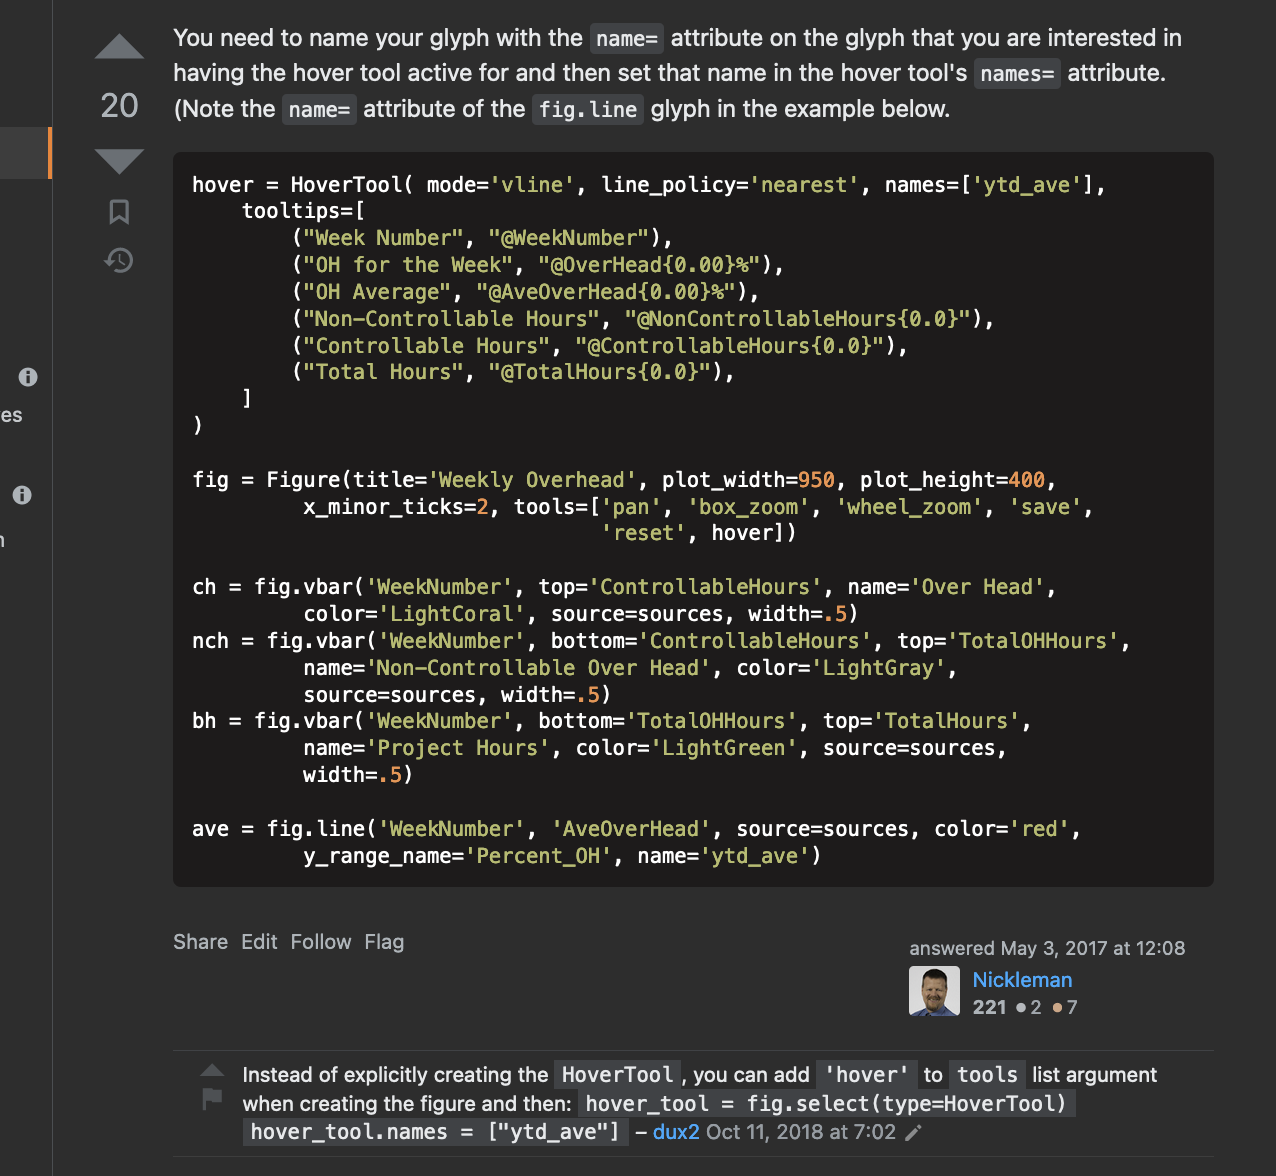

In [53]:
# ideal coordinates top to bottom: 47.8 - 47.25, left to right: -122.65 - -121.95 
((y_range[-1] + y_range[0]) / 2)

46.566250499999995

In [56]:
np.mean(y_range)

46.566250499999995